## Aircraft Detection - Inference

In [1]:
import torch
from bbox_utils import *
import torch
from torch import nn
import torch.optim as optimizer
import torch.nn.functional as f
from pathlib import Path
import os
import bbox_utils
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Conv2d, Dropout, MaxPool2d, BatchNorm1d, BatchNorm2d
import pandas as pd
import json

In [84]:
new_size = 128

def resize_im_rowwise(row):
    return bbox_utils.transformsImg(row['path'], new_size)

def display_bbox_target_vector(img,target,np_bboxs):
    fig, ax = plt.subplots()
    to_draw = np_bboxs[np.array(target, dtype=bool)]

    ax.imshow(img)
    for bbox in to_draw:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0],
                                bbox[3]-bbox[1], linewidth=1, edgecolor=bbox_utils.get_random_color(), facecolor='none')
        ax.add_patch(rect)
    plt.show()

In [13]:
#Loading the model

dir_root = os.path.abspath('')
model_dir = Path(dir_root, '../data/model/1670060911.176875.pth') # replace here the name of the model you want to use

In [52]:
bboxs = bbox_utils.generate(10, 130//4, 10, (new_size, new_size))
print(len(bboxs))

175692


In [4]:
train_imgs = Path(dir_root, '../data/train')
test_imgs = Path(dir_root, '../data/test')
annot_dir = Path(dir_root, '../data/annot/rareplanes.json')

In [37]:
with open(annot_dir) as json_data:
    data = json.load(json_data)

annot_train = pd.DataFrame(data['categories'])
annot_train.drop(['loc_id', 'cat_id', 'location', 'role', 'role_id', 'is_plane', 'num_engines', 'propulsion', 'canards', 'num_tail_fins', 'wing_position', 'wing_type',
                'length', 'wingspan', 'area', 'faa_wingspan_class', 'Public_Train', 'Public_Test', 'partialDec', 'truncated', 'new_area', 'area_pixels', 'id'], axis=1, inplace=True)
annot_train.rename(columns={"image_fname": "name"}, inplace=True)

annot_train = annot_train.groupby(['image_id']).agg(
    tuple).applymap(np.array).reset_index()

annot_train.drop(annot_train.index.to_list()[100:], axis=0, inplace=True)

annot_train['path'] = annot_train.apply(
    lambda row: str(train_imgs) + "/"+row['name'][0], axis=1)
annot_train.drop(['name', 'image_id'], axis=1, inplace=True)

In [38]:
annot_train['image'] = annot_train.apply(resize_im_rowwise, axis=1)
annot_train.head()

,bbox,path,image
0,"[[0.0, 455.2384377140552, 123.27844765782356, ...",/zhome/3a/d/136926/AIRCRAFT/src/../data/train/...,"[[[0.20588235294117646, 0.17450980392156862, 0..."
1,"[[246.756015393883, 236.86537762917578, 48.825...",/zhome/3a/d/136926/AIRCRAFT/src/../data/train/...,"[[[0.10392156862745097, 0.09019607843137255, 0..."
2,"[[33.902556490153074, 465.3724965797737, 124.4...",/zhome/3a/d/136926/AIRCRAFT/src/../data/train/...,"[[[0.056862745098039215, 0.07352941176470588, ..."
3,"[[107.15582166425884, 23.3506712121889, 65.156...",/zhome/3a/d/136926/AIRCRAFT/src/../data/train/...,"[[[0.403921568627451, 0.34411764705882353, 0.2..."
4,"[[458.14158141613007, 236.58495056815445, 27.1...",/zhome/3a/d/136926/AIRCRAFT/src/../data/train/...,"[[[0.2519607843137255, 0.20392156862745098, 0...."


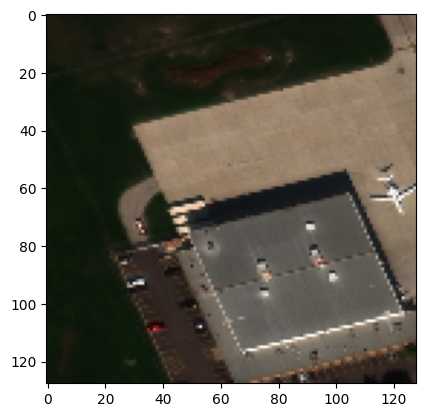

In [48]:
plt.figure()
plt.imshow(annot_train['image'][78])
plt.show()

In [63]:
class AircraftModel(nn.Module):
    def __init__(self):
        super(AircraftModel, self).__init__()
        self.conv = nn.Sequential(
            Conv2d(3, 192, kernel_size=7, stride=2),
            nn.LeakyReLU(0.1),
            MaxPool2d(2, 2),
            Conv2d(192, 256, 3, 1),
            nn.LeakyReLU(0.1),
            MaxPool2d(2, 2),
            Conv2d(256, 512, 1, 1),
            nn.LeakyReLU(0.1),
            nn.Flatten(start_dim=1),
            nn.Dropout(0.5)
        )

        self.connected = nn.Sequential(
            nn.LazyLinear(out_features=64),
            nn.ReLU(),
            nn.Linear(64, out_features=len(bboxs), bias=False)
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x,0) #had to add this otherwise we get an error related to shapes - it shouldn't alter the result
        x = self.connected(x)
        return x

In [64]:
model = AircraftModel().double()
model.load_state_dict(torch.load(model_dir,map_location=torch.device('cpu')))
model.eval()

/zhome/3a/d/136926/.local/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


AircraftModel(
  (conv): Sequential(
    (0): Conv2d(3, 192, kernel_size=(7, 7), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.1)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.1)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Dropout(p=0.5, inplace=False)
  )
  (connected): Sequential(
    (0): LazyLinear(in_features=0, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=175692, bias=False)
  )
)

In [87]:
image_index = 57

input_init = torch.from_numpy(annot_train['image'][image_index])
input = torch.permute(input_init,(2,1,0))
output = model(input)
print("Output: ",output)
print("Planes found: ",sum(output.detach().numpy())) #when the model outputs proper 1's and 0'2 this should make more sense

Output:  tensor([ 9.7221e-05,  2.4653e-04,  2.9070e-05,  ..., -4.7255e-05,
         1.4441e-05, -1.5866e-04], dtype=torch.float64,
       grad_fn=<SqueezeBackward3>)
Planes found:  0.02822936694268218


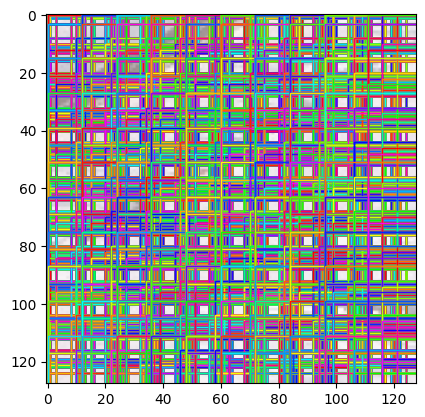

In [86]:
np_bboxs = np.asarray(list(map(lambda BBOX: [BBOX.arr[0], BBOX.arr[1], BBOX.arr[2], BBOX.arr[3]], bboxs)))
display_bbox_target_vector(annot_train['image'][image_index],output.detach().numpy(),np_bboxs)